In [10]:
import pickle as pkl
import lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import importlib
import time

from tensorflow.keras.datasets import imdb
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add, ZeroPadding1D


importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

## Helper Functions

In [62]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [19]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        plt.legend()
        plt.show()
        
        plt.hist(predictions, label = 'Prediction Distribution')
        plt.legend()
        plt.show()    
        
        plt.hist(actual, label = 'Actual Distribution')
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [36]:
tqdm.pandas()

In [37]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [4]:
import sys

In [ ]:
!{sys.executable} -m list

## Reading the Data

In [6]:
iterator = True


if iterator == True:
    
    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
if iterator == False:

    drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                         lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                        "drug_fingerprint_encoded_padded": \
                                                                                        lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

## CNN in Chunks

In [58]:

#drugbank = drugbank_reader.__next__()


In [ ]:
drugbank

In [4]:
def identity_block(X, kernel_size, filters):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    # Component 1
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2 
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3 
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

In [5]:
def convolutional_block(X, kernel_size, filters, s = 2):
    
    # Number Of Filters For Each Block 
    F1, F2, F3 = filters
    
    # Save Input For Shortcut
    X_shortcut = X
    
    ## Main Path 
    # Component 1 
    X = Conv1D(filters = F1, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 2
    X = Conv1D(filters = F2, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Component 3
    X = Conv1D(filters = F3, kernel_size = kernel_size, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    ## Shortcut Path
    X_shortcut = Conv1D(filters = F3, kernel_size = 16, strides = s, padding = 'valid', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    # Add Shortcut Path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [6]:
def ResNet_1D(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv1D(filters = 64, kernel_size = 16, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Stage 2 - 1 Conv Block & 2 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [64, 64, 128], s = 1)
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    X = identity_block(X, kernel_size = 1, filters = [64, 64, 128])
    
    # Stage 3 - 1 Conv Block & 3 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    X = identity_block(X, kernel_size = 1, filters = [128, 128, 256])
    
    # Stage 4 - 1 Conv Block & 5 Identity Blocks
    X = convolutional_block(X, kernel_size = 16, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    X = identity_block(X, kernel_size = 1, filters = [256, 256, 512])
    
    # Stage 5 - 1 Conv Block & 2 Identity Blocks 
    X = convolutional_block(X, kernel_size = 16, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    X = identity_block(X, kernel_size = 1, filters = [512, 512, 1024])
    
    
    X = GlobalAveragePooling1D()(X)
    X = Flatten()(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [66]:
def OneDimensional_VGG(input_shape = (30723, 1)):
    
    X_input = Input(input_shape)
    
    # Convolution Block 1
    X = Conv1D(filters = 64, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB1-C1')(X_input)
    X = Conv1D(filters = 64, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB1-C2')(X)
    X = BatchNormalization(name = 'CB1-BN1')(X)
    X = AveragePooling1D(name = 'CB1-P1')(X)
    X = Dropout(0.6, name = 'CB1-DO1')(X)
    
    # Convolution Block 2
    X = Conv1D(filters = 128, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB2-C1')(X)
    X = Conv1D(filters = 128, kernel_size = 2, strides = 1, activation = 'relu', padding = 'same', kernel_initializer = glorot_uniform(), name = 'CB2-C2')(X)
    X = BatchNormalization(name = 'CB2-BN1')(X)
    X = AveragePooling1D(name = 'CB2-P1')(X)
    X = Dropout(0.6, name = 'CB2-DO1')(X)

    # Convolution Block 3
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP1')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP2')(X)
    X = Conv1D(filters = 256, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB3-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB3-ZP3')(X)
    X = BatchNormalization(name = 'CB3-BN1')(X)
    X = AveragePooling1D(name = 'CB3-P1')(X)
    X = Dropout(0.6, name = 'CB3-DO1')(X)
    
    # Convolution Block 4
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP1')(X)
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP2')(X)
    X = Conv1D(filters = 512, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB4-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB4-ZP3')(X)
    X = BatchNormalization(name = 'CB4-BN1')(X)
    X = AveragePooling1D(name = 'CB4-P1')(X)
    X = Dropout(0.6, name = 'CB4-DO1')(X)
    
    # Convolution Block 5
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C1')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP1')(X)
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C2')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP2')(X)
    X = Conv1D(filters = 1024, kernel_size = 2, strides = 2, activation = 'relu', kernel_initializer = glorot_uniform(), name = 'CB5-C3')(X)
    X = ZeroPadding1D(int(int(X.shape[1]) / 2), name = 'CB5-ZP3')(X)
    X = BatchNormalization(name = 'CB5-BN1')(X)
    X = AveragePooling1D(name = 'CB5-P1')(X)
    X = Dropout(0.6, name = 'CB5-DO1')(X)
    
    X = GlobalAveragePooling1D(name = 'GP-1')(X)
    X = Flatten(name = 'Flat-1')(X)
    X = Dense(1, kernel_initializer = glorot_uniform())(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [67]:
model = OneDimensional_VGG()

In [68]:
# model = ResNet_1D()

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30723, 1)          0         
_________________________________________________________________
CB1-C1 (Conv1D)              (None, 30723, 64)         192       
_________________________________________________________________
CB1-C2 (Conv1D)              (None, 30723, 64)         8256      
_________________________________________________________________
CB1-BN1 (BatchNormalization) (None, 30723, 64)         256       
_________________________________________________________________
CB1-P1 (AveragePooling1D)    (None, 15361, 64)         0         
_________________________________________________________________
CB1-DO1 (Dropout)            (None, 15361, 64)         0         
_________________________________________________________________
CB2-C1 (Conv1D)              (None, 15361, 128)        16512     
__________

In [70]:
model_optimizer = tensorflow.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)
hidden_dims_3 = 32
batch_size = 10
epochs = 5
trim_width = 0

class_weight = {0: 1.,
                1: 5}


In [71]:
#Uncomment to read model
#model = tensorflow.keras.models.load_model('models/CNN_GPU_VGG_85p.model')
model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])

In [46]:
%%time

#drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 500, iterator = True, converters={"target_gene_encoded_padded": \
#                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
#                                                                                    "drug_fingerprint_encoded_padded": \
#                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', iterator = False, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})
drugbank = drugbank.sort_values('drug_id')
drugbank_reader = np.array_split(drugbank, len(drugbank)/500)


CPU times: user 11min 14s, sys: 13 s, total: 11min 27s
Wall time: 11min 26s


In [72]:
drugbank_test = drugbank_reader[0]
#drugbank_test = drugbank_reader.__next__()

In [87]:
## Use if DRUGBANK DF is already in memory


In [49]:
drugbank_reader[0]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
73873,DB00001,BE0000048,2246728737 3542456614 2245384272 1506563592 22...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1869,9397,-7528,19353,104,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
21967,DB00001,BE0000690,2246728737 3542456614 2245384272 1506563592 22...,ATGTCCACTGAAAACACTTCTTTGGTCGTTGAACTATTGGAGTACG...,0,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1602,9397,-7795,19620,104,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2257,DB00001,BE0003281,2246728737 3542456614 2245384272 1506563592 22...,ATGGCCAACCTGGAGCGCACCTTCATCGCCATCAAGCCGGACGGCG...,0,[0 3 2 2 1 1 0 0 1 1 3 2 2 0 2 1 2 1 0 1 1 3 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",459,9397,-8938,20763,104,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
56133,DB00006,BE0002540,2246728737 3542456614 2245384272 1506563592 22...,ATGCCATCTGTGAAGATCGGTATCATCGGTGCGGGGAGCGCGGTGT...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1443,3003,-1560,19779,6498,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
43118,DB00006,BE0001635,2246728737 3542456614 2245384272 1506563592 22...,ATGAAGCTTTTAATTACCGGTGGATGTGGCTTCCTTGGGAGTAATC...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1017,3003,-1986,20205,6498,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82248,DB00126,BE0000168,2245384272 4022716898 2245273601 3081284555 29...,ATGAGGGCCCAGGAGGACCTCGAGGGCCGGACACAGCATGAAACCA...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 4, 0, 2, 2, 7, ...",1797,228,1569,19425,9273,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
82272,DB00126,BE0002203,2245384272 4022716898 2245273601 3081284555 29...,ATGGCGACGGTGGGGGCTCCGCGGCACTTCTGCCGCTGCGCCTGCT...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 4, 0, 2, 2, 7, ...",1053,228,825,20169,9273,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
56757,DB00126,BE0002622,2245384272 4022716898 2245273601 3081284555 29...,ATGGAACAACAACCATTAACATTAACGGCGGCGACAACTCGTGCGC...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 4, 0, 2, 2, 7, ...",2031,228,1803,19191,9273,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
82323,DB00126,BE0004338,2245384272 4022716898 2245273601 3081284555 29...,ATGGAGCTGTCTTGGCATGTAGTCTTTATTGCCCTGCTAAGTTTTT...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 4, 0, 2, 2, 7, ...",5784,228,5556,15438,9273,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


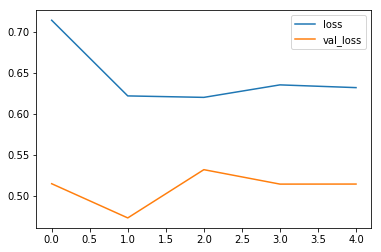

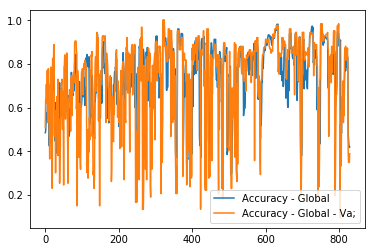

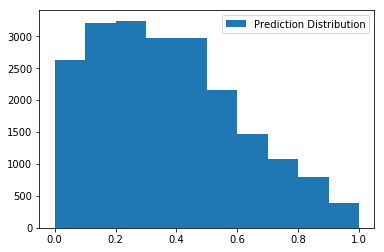

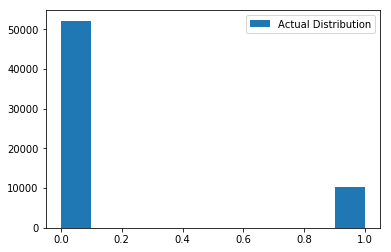

 - 26s - loss: 0.6319 - binary_accuracy: 0.8511 - val_loss: 0.5146 - val_binary_accuracy: 0.8175



In [73]:
global_history = []
global_val_history = []
predictions = []
actual = []

with open('data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)
    

for drugbank in tqdm(drugbank_reader[1:]):
    
    
    print('Reading chunk from file..')
    #drugbank = drugbank_reader.__next__()
    
    #drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
    #                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
    #drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

    
    print('Sampling..')
    train_df_inter, test_df = train_test_split(drugbank)

    ##USE TO FORCE TRAIN NEGATIVE SAMPLES ON LOW EPOCH
    train_df = pd.DataFrame()
    
    if len(train_df_inter[train_df_inter['Y'] == 0]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 0].sample(frac = 1.0))
    1.0
    if len(train_df_inter[train_df_inter['Y'] == 1]) > 2:
        train_df = train_df.append(train_df_inter[train_df_inter['Y'] == 1].sample(frac = 1.0))

    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)

    print('Trimming..')
    X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
    X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]
    
    X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
    X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)


    X_0 = np.hstack((X_0, X_1))
    X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')
    
    print("X0 Shape : " + str(X_0.shape))
    print("X1 Shape : " + str(X_1.shape))
    
    print("X0 Test Shape : " + str(X_0_test.shape))
    print("X1 Test Shape : " + str(X_1_test.shape))
    
    
    history = model.fit(X_0[..., np.newaxis], Y,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[plot_losses],
                          class_weight=class_weight,
                          validation_data=(X_0_test[..., np.newaxis], Y_test), verbose = 2)


    actual.extend(Y.tolist())
    predictions.extend(model.predict(X_0_test[..., np.newaxis]).ravel())
    
    global_val_history.extend(history.history['val_binary_accuracy'])
    global_history.extend(history.history['binary_accuracy'])


    

In [75]:
model.save('models/CNN_GPU_VGG_full_5_blocks.model')

In [74]:
trim_width = 0

print('Padding..') 
X_0 = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1 = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))
Y   = np.array(list(drugbank_test['Y']))


X_0_test = np.array(list(drugbank_test['target_gene_encoded_padded']))
X_1_test = np.array(list(drugbank_test['drug_fingerprint_encoded_padded']))

Y_test   = np.array(list(drugbank_test['Y']))

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)

print('Trimming..')
X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]

X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]


X_0 = X_0.astype(int) + 1
X_1 = X_1.astype(int) + 1
Y   = Y.astype(int)

X_0_test = X_0_test.astype(int) + 1
X_1_test = X_1_test.astype(int) + 1
Y_test   = Y_test.astype(int)

print(X_0.shape)
print(X_1.shape)

print(X_0_test.shape)
print(X_1_test.shape)


X_0 = np.hstack((X_0, X_1))
X_0_test = np.hstack((X_0_test, X_1_test))



Y_pred_test = model.predict(X_0[..., np.newaxis])

Padding..
(503, 21222)
(503, 9501)
(503, 21222)
(503, 9501)
Trimming..
(503, 21222)
(503, 9501)
(503, 21222)
(503, 9501)


(array([321.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

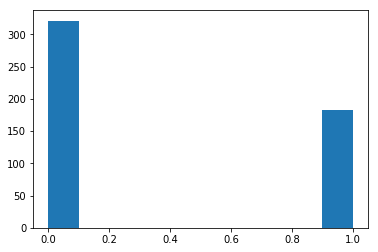

In [76]:
plt.hist(Y_test)

(array([ 10.,  31.,  73.,  80., 103., 119.,  59.,  19.,   4.,   5.]),
 array([0.13304681, 0.1991218 , 0.2651968 , 0.3312718 , 0.39734679,
        0.46342179, 0.52949679, 0.59557179, 0.66164678, 0.72772178,
        0.79379678]),
 <a list of 10 Patch objects>)

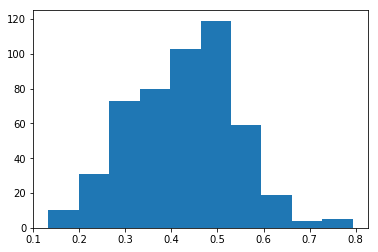

In [77]:
plt.hist(Y_pred_test)

In [78]:
Y_pred_test = [1 if (i > 0.5) else 0 for i in Y_pred_test ]
cm = confusion_matrix(Y_test, Y_pred_test)

In [79]:
cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

array([[0.77570093, 0.22429907],
       [0.68131868, 0.31868132]])

In [80]:
f1_score(Y_test, Y_pred_test)

0.3717948717948718

Confusion matrix, without normalization
[[249  72]
 [124  58]]
Normalized confusion matrix
[[0.77570093 0.22429907]
 [0.68131868 0.31868132]]


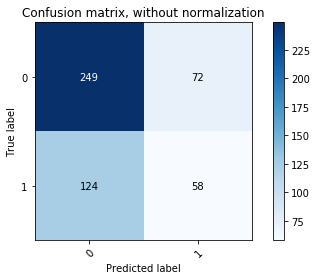

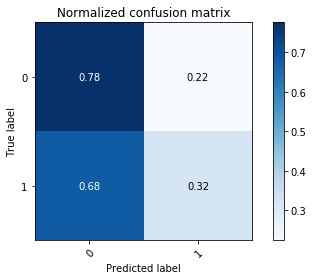

In [81]:
plot_confusion_matrix(Y_test, Y_pred_test, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred_test, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

In [82]:
print(classification_report(Y, Y_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       321
          1       1.00      1.00      1.00       182

avg / total       1.00      1.00      1.00       503



In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30723, 1)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5121, 64)          192       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 854, 64)           8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 854, 64)           256       
_________________________________________________________________
average_pooling1d_1 (Average (None, 427, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 213, 128)          16512     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 106, 128)          32896     
__________